In [8]:
from collections import deque
import random
import math
import numpy as np
from qiskit import *
from qiskit.circuit.library.standard_gates import MCXGate

In [9]:
# ------ 計算使用函數 -----------

# 計算兩個二進位數的hamming distance
def ham(a,b):
    res = 0
    for i in range(len(a)):
        if a[i] != b[i]:
            res = res + 1
    return res

# 將list第n個位置切割丟到字串最後面
def rotate(l, n):
    return l[n:] + l[:n]

# 矩陣轉置
def transpose(list1):
    return [list(row) for row in zip(*list1)]

# 檢查電路是否可化簡 (2to1)
def Simplified(gate1,gate2,flag):
    point = -1
    for i in range(len(gate1)):
        if gate1[i] == gate2[i]:
            continue
        elif gate1[i] == '1' and gate2[i] == '0':
            if (point != -1):
                return 0
            point = i
        elif gate1[i] == '0' and gate2[i] == '1':
            if (point != -1):
                return 0
            point = i
        else:
            return 0
    if flag:
        print(gate1,gate2,end="")
    new_gate = gate1
    new_gate[point] = ' '
    if flag:
        print(" >> ",new_gate)
    return new_gate

In [10]:
# ------ 求解使用函數 -----------

# 驗證input的真值表是否可逆
def check_invertable(input,flag):
    if flag:
        print("----------")
        print("檢測輸入的真值表:",end="")
    if sum(input) == (1 + len(input)) * len(input) / 2 - len(input):
        bits_size = int(math.log(len(input),2))
        if flag:
            print("合格")
        return bits_size
    else:
        if flag:
            print("不合格")
        return 0

# 不相鄰的pair轉成相鄰的pairs
def Non_adjacent(pair,flag):
    if flag:
        print("-- Adjacent element ",pair)
    # 要轉換r次
    h = ham(pair[0],pair[1])
    items = []
    while(h != 0):
        r = random.randint(0,len(pair[0])-1)
        if pair[0][r] == pair[1][r]:
            continue
        tmp = list(pair[0])
        # 找pair中，第一個不同的bit
        if tmp[r] == '1':
            tmp[r] = '0'
        else:
            tmp[r] = '1'
        items.append(pair[0])
        pair = (''.join(tmp),pair[1])
        h = h - 1
    items.append(pair[1])
    # print("-- Path ",items)
    # item[first] 交換到 item[last]
    res = []
    res_tmp = []
    for i in range(len(items)-1):
        res.append((items[i],items[i+1]))
    for i in range(len(res) - 1):
        res_tmp.append(res[len(res)- 2 - i])
    res = res + res_tmp
    if flag:
        print("-- Non adjacent elements ",end="")
        for r in res:
            print(r,end="")
        print()
    return res

# 使用input建立truth table
def build_truth_table(input,flag):
    truth_table = {}
    if flag:
        print("----------")
        print("原始真值表")
        print("----------")
    for i in range(2**bits_size):
        truth_table[format(i, "b").zfill(bits_size)] = format(input[i], "b").zfill(bits_size)
        #print(format(i, "b").zfill(bits_size),'>',format(input[i], "b").zfill(bits_size))  
    if flag:
        for item in truth_table.items():
            print(item)
    return truth_table

# 去掉非cycle的值(即指向自己的value)
def kill_non_cycle(truth_table,flag):
    if flag:
        print("----------")
        print("去掉非cycle的真值表")
        print("----------")
    for key in list(truth_table):
        if key == truth_table[key]:
            truth_table.pop(key)
    if flag:
        for item in truth_table.items():
            print(item)
    return truth_table

# 建立形成cycle的list
def build_cycles(truth_table,f):
    flag = {}
    for key in truth_table:
        flag[key] = 0
    cycles = []
    for key in truth_table:
        if flag[key] == 1:
            continue
        tmp = []
        tmp.append(key)
        flag[key] = 1
        point = truth_table[key]
        while point != key:
            tmp.append(point)
            flag[point] = 1
            point = truth_table[point]
        cycles.append(tmp)
    if f:
        print("----------")
        print("形成的cycle")
        print("----------")
        for cycle in cycles:
            print(cycle)
    return cycles

# cycle 轉成 transposition
def decompose_cycles(cycles,flag):
    transpositions = []
    if flag:
        print("----------")
        print("破壞cycle，建立transposition")
        print("----------")
    for cycle in cycles:
        if len(cycle) == 2:
            # 兩個value形成的cycle只要交換就好
            temp = []
            temp.append(cycle)
            transpositions.append(temp)
            continue
        # 找尋cycle link破壞點(挑選Hammin Distances最短的兩者)
        ham_dis = []
        for i in range(len(cycle)):
            if i == len(cycle) - 1:
                h = ham(cycle[i],cycle[0])
            else:
                h = ham(cycle[i],cycle[i+1])
            ham_dis.append(h)
        # index 為 切換到下一個狀態，漢明距離最長者 (FCFS)
        if flag:
            print(cycle)
            print(">> hamming distance ",ham_dis)
        index = ham_dis.index(max(ham_dis))
        if flag:
            print(">> cut at ",cycle[index],'and',cycle[(index+1)%len(cycle)])
        #重新排列交換的順序
        cycle = rotate(cycle,(index+1)%len(cycle))
        tmp = list(reversed(cycle))
        tran_temp = []
        if flag:
            print(">> ",end="")
        for i in range(len(tmp)-1):
            pair = (tmp[i],tmp[i+1])
            tran_temp.append(pair)
            if flag:
                print(pair,end="")
        if flag:
            print()
        transpositions.append(tran_temp)
    return transpositions
    
# 轉換transpositions中，"不相鄰"的元素成"相鄰"的元素群
# (不相鄰:hamming distance > 1)
def de_adjacent(transpositions,flag):
    res = []
    if flag:
        print("----------")
        print('將"不相鄰"的元素轉成"相鄰"的元素群')
        print("----------")
    for transposition in transpositions:
        if flag:
            print(">> transposition",transposition)
        new_transposition = []
        for pair in transposition:
            # 不相鄰
            if ham(pair[0],pair[1]) > 1:
                pairs = Non_adjacent(pair,flag)
                for pair in pairs:
                    new_transposition.append(pair)
            # 相鄰
            else:
                new_transposition.append(pair)
        res.append(new_transposition)
        if flag:
            print("-- New transposition:",new_transposition)  
    return res

# 轉成電路圖
# '0' 表示 0-control : '1' 表示 1-control : 'X' 表示 Not Gate  : ' ' 表示 Identity gate
def build_circuit(transpositions,flag):
    if flag:
        print("----------")
        print('印出Gate List')
        print("----------")
    circuit = []
    for transposition in transpositions:
        for pair in transposition:
            tmp = []
            for i in range(len(pair[0])):
                if pair[0][i] == pair[1][i]:
                    tmp.append(pair[0][i])
                else:
                    tmp.append('X')
            circuit.append(tmp)
    if flag:
        print(circuit)
    return circuit

# 化簡電路
def simplize(circuit,flag):
    if flag:
        print("----------")
        print('化簡電路')
        print("----------")
    new_circuit = []
    tmp = [] # 上一個 Gate
    for gate in circuit:
        if tmp == []:
            tmp = gate
            new_circuit.append(gate)
        else:
            #電路可化簡 (Gate 相同)
            if tmp == gate:
                if flag:
                    print(gate,gate,">> Delete")
                tmp = []
                new_circuit.pop()
                continue
            #電路可化簡 (1 bit flip)
            elif Simplified(tmp,gate,flag) != 0:
                new_circuit.pop()
                new_circuit.append(tmp)
            #電路不可化簡    
            else:
                tmp = gate
                new_circuit.append(gate)
    if flag:
        print(new_circuit)
    return new_circuit
                
# 電路驗證 將所有值帶入
def verification(circuit,bits_size,flag):
    for i in range(2**bits_size):
        binary = format(i, "b").zfill(bits_size)
        exc = format(input[i], "b").zfill(bits_size)
        if flag:
            print("----------")
            print("輸入值",binary)
            print("期望值",exc)
        for gate in circuit:
            index = 0
            tmp = list(binary)
            if 'x' in gate:
                for i in range(len(gate)):
                    if gate[i] == 'x':
                        if tmp[i] == '0':
                            tmp[i] = '1'
                        elif tmp[i] == '1':
                            tmp[i] = '0'
            else:
                for i in range(len(gate)):
                    if gate[i] == 'X':
                        index = i
                    elif gate[i] != tmp[i] and gate[i] != ' ':
                        break
                    #結束前反轉XOR的bit(不能提早做，因為要確認其他bit都相同)
                    if i == len(gate) - 1:
                        if tmp[index] == '0':
                            tmp[index] = '1'
                        else:
                            tmp[index] = '0'
            binary = ''.join(tmp)
            if flag:
                print("經過 gate",gate,"後 >","當前值",binary)        
        if binary == exc:
            if flag:
                print("合格")
        else:
            print("不合格!")
            return False
    if flag:
        print("掃描完成，全部正確!")
    return True

def build_matrix(circuit):
    print("----------")
    print('矩陣轉置',',Gate數量:',len(circuit))
    print("----------")
    circuit = transpose(circuit)
    for gate in circuit:
        print(gate)

def de_zero(circuit):
    res = []
    for gates in circuit:
        # 取得 '1','0','X'的位置
        if '0' not in gates:
            res.append(gates)
            continue
        tmp = gates.copy()
        for index, value in enumerate(tmp):
            if value == '0':
                tmp[index] = 'x'
                gates[index] = '1'
            else:
                tmp[index] = ' '
                
        res.append(tmp)
        res.append(gates)
        res.append(tmp)
    return res

def de_xgate(circuit):
    res = []
    tmp = []
    for gates in circuit:
        if not tmp:
            res.append(gates)
            tmp = gates
        else:
            if 'x' in gates and 'x' in tmp:
                new_gate = []
                for i in range(len(gates)):
                    if gates[i] == tmp[i]:
                        new_gate.append(' ')
                    else:
                        new_gate.append('x')
                res.pop()
                if 'x' in new_gate:
                    res.append(new_gate)
                tmp = res[-1]
            else:
                res.append(gates)
                tmp = gates 
        tmp = gates
    return res
        
# 建立 量子電路
my_gate = QuantumCircuit(1)
my_gate.x(0)
X = my_gate.to_gate(label='X')

def to_quantum_circuit(circuit,bits_size):
    cir = QuantumCircuit(bits_size)
    for gates in circuit:
        # 取得 '1','x','X'的位置
        one = []
        xgate = []
        xor = -1
        print()
        for i in range(len(gates)):
            if gates[i] == '1':
                one.append(i)
            elif gates[i] == 'x':
                xgate.append(i)
            elif gates[i] == 'X':
                xor = i
        if len(xgate) == 0:
            one.append(xor)
            cir.append(MCXGate(len(one)-1),one)
        else:
            for i in xgate:
                cir.append(X, [i])
    return cir 

In [11]:
# TODO
input = [0,1,2,3,6,7,5,4,10,11,9,8,13,12,15,14] # Full adder
input = [0,1,2,3,4,5,7,6] #(a) Toffoli
# input = [0,1,2,3,6,7,5,4] #(b) Peres 
# input = [0,1,2,3,4,6,5,7] #(c) Fredkin 
# input = [0,1,3,2,5,4,7,6] #(d) OR
# input = [0,1,3,2,4,5,6,7] #(e) Toffoli with one negative control line

# 其他變數
run = 1 #測試次數
printinfo = True #列印過程

bits_size = 0 # 量子位元數
truth_table = {} # 真值表
cycles = [] # 形成的迴圈
transpositions = [] # 破解迴圈後形成的轉換
circuit = [] # 建立好的電路
best_circuit = [] #最佳電路
best_depth = 99999 #最低深度



bits_size = check_invertable(input,printinfo) # 檢測輸入的真值表是否合法
truth_table = build_truth_table(input,printinfo) # 建立真值表
truth_table = kill_non_cycle(truth_table,printinfo) # 去掉指向自己的值(只留下會形成迴圈的值)
cycles = build_cycles(truth_table,printinfo) # 建立迴圈

for i in range(run):
    # 建立一個電路
    transpositions = decompose_cycles(cycles,printinfo) # 分解迴圈
    transpositions = de_adjacent(transpositions,printinfo) # 分解不相鄰的轉換
    circuit = build_circuit(transpositions,printinfo) # 建立電路
    circuit = simplize(circuit,printinfo) # 化簡電路
    if len(circuit) < best_depth:
        best_depth = len(circuit)

        best_circuit = circuit

build_matrix(best_circuit) # 轉成矩陣後輸出

----------
檢測輸入的真值表:合格
----------
原始真值表
----------
('000', '000')
('001', '001')
('010', '010')
('011', '011')
('100', '100')
('101', '101')
('110', '111')
('111', '110')
----------
去掉非cycle的真值表
----------
('110', '111')
('111', '110')
----------
形成的cycle
----------
['110', '111']
----------
破壞cycle，建立transposition
----------
----------
將"不相鄰"的元素轉成"相鄰"的元素群
----------
>> transposition [['110', '111']]
-- New transposition: [['110', '111']]
----------
印出Gate List
----------
[['1', '1', 'X']]
----------
化簡電路
----------
[['1', '1', 'X']]
----------
矩陣轉置 ,Gate數量: 1
----------
['1']
['1']
['X']


In [12]:
# 消去zero controll
print("\n去掉zero controll")
best_circuit = de_zero(best_circuit)
build_matrix(best_circuit)
print("\n去掉重複的X gate")
best_circuit = de_xgate(best_circuit)
build_matrix(best_circuit)
print("\n再次化簡")
circuit = simplize(best_circuit,False) # 化簡電路
build_matrix(best_circuit)


去掉zero controll
----------
矩陣轉置 ,Gate數量: 1
----------
['1']
['1']
['X']

去掉重複的X gate
----------
矩陣轉置 ,Gate數量: 1
----------
['1']
['1']
['X']

再次化簡
----------
矩陣轉置 ,Gate數量: 1
----------
['1']
['1']
['X']



Gate count: OrderedDict([('ccx', 1)])
depth: 1


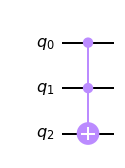

In [13]:
quantumCircuit = to_quantum_circuit(circuit,bits_size)
print("Gate count:",quantumCircuit.count_ops())
print("depth:",quantumCircuit.depth())
quantumCircuit.draw('mpl')

Gate count: OrderedDict([('cx', 6), ('t', 4), ('tdg', 3), ('h', 2)])
depth: 11


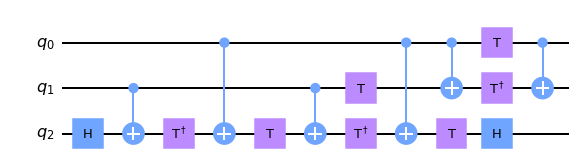

In [14]:
# 使用函式化簡
# https://qiskit.org/documentation/apidoc/synthesis_aqc.html?highlight=aqc#module-qiskit.transpiler.synthesis.aqc
decomposed_quantumCircuit = transpile(quantumCircuit, unitary_synthesis_method='aqc',basis_gates=['h','cx','t','tdg','x','rz'],optimization_level=3)
print("Gate count:",decomposed_quantumCircuit.count_ops())
print("depth:",decomposed_quantumCircuit.depth())
decomposed_quantumCircuit.draw('mpl')

In [15]:
# 確認相同
from qiskit.quantum_info import Statevector
Statevector.from_instruction(decomposed_quantumCircuit).equiv(Statevector.from_instruction(quantumCircuit))

True